In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.transform import resize
from skimage.filters import threshold_otsu
import cv2
from Utils import *

In [2]:
color_channels = 3
pixel_depth = 255.0
bbox_horz_exp = 1  # Pixels to expand bounding boxes by in each horizontal direction

**Preprocess images**

In [3]:
def import_bboxes(path):
    path = data_dir + path
    mat = h5py.File(path + '/digitStruct.mat', 'r')
    dig = mat['digitStruct']
    bbox = dig['bbox']
    keys = dig[bbox[0, 0]].keys()
    data = {k: [] for k in keys}
    n_samples = bbox.shape[0]
    data['n_digits'] = [dig[bbox[i, 0]]['label'][()].shape[0] for i in range(n_samples)]
    for key in keys:
        res = []
        for i in range(n_samples):
            n_digs = data['n_digits'][i]
            ds = [dig[bbox[i, 0]][key][()][j, 0] for j in range(n_digs)]
            if n_digs != 1:
                ds = [int(mat[d][()][0, 0]) for d in ds]
            else:
                ds = [int(d) for d in ds]
            data[str(key)].append(ds)
    return n_samples, data
def import_images(path, n_images):
    path = data_dir + path
    images = []
    for i in range(1, n_images + 1):
        img = (ndimage.imread(path + '/' + str(i) + '.png').astype(float) - pixel_depth / 2) / pixel_depth
        images.append(img)
        if (i + 1) % 10 == 0:
            sys_pr('\rImported image ' + str(i + 1))
    print()
    return images
def local_contrastive_norm(img):
    img = deepcopy(img)
    img += 0.5
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    float_gray = gray.astype(np.float32) / 255.0
    blur = cv2.GaussianBlur(float_gray, (0, 0), sigmaX=2, sigmaY=2)
    num = float_gray - blur
    blur = cv2.GaussianBlur(num*num, (0, 0), sigmaX=25, sigmaY=25)
    den = cv2.pow(blur, 0.5)
    gray = num / den
    cv2.normalize(gray, dst=gray, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    return gray - 0.5
def extract_digits(images, bboxes, dims=(14, 29)):
    new_n = sum(bboxes['n_digits'])
    digh, digw = dims
    digw += bbox_horz_exp * 2
    res = np.ndarray(shape=(new_n, digh, digw, color_channels), dtype=np.float32)
    lbls = np.ndarray(shape=(new_n), dtype=np.int32)
    x_i = 0
    for i in range(len(images)):
        for j in range(bboxes['n_digits'][i]):
            top = bboxes['top'][i][j]
            left = bboxes['left'][i][j]
            
            if bboxes['width'][i][j] == 0:
                print(i, j)
            if bboxes['height'][i][j] == 0:
                print('height', i, j)
            
            h = top + bboxes['height'][i][j]
            w = left + bboxes['width'][i][j] + bbox_horz_exp
            top = max(0, top)
            left = max(0, left - bbox_horz_exp)
            
            img = images[i][top:h, left:w, :]
#             if img.shape[1] == 0:
#                 print(img.shape, i, j, images[i].shape, top, left,bboxes['height'][i][j], bboxes['width'][i][j])
            img = resize(np.ascontiguousarray(img), (digh, digw))
#             img = local_contrastive_norm(img.astype(np.float32))
        
#             img_flat = img.flatten()  # Use Otsu's method to invert light-on-dark digits (works if the fewer digit pixels)
#             thresh = threshold_otsu(img_flat)
#             mass_below = sum(img_flat <= thresh)
#             mass_above = sum(img_flat > thresh)
#             if mass_below > mass_above:
#                 img = 0.5 - img
            res[x_i] = img
        
            lbl = bboxes['label'][i][j]
            if lbl == 10:
                lbl = 0
            lbls[x_i] = lbl
            x_i += 1
        if i % 10 == 0:
            sys_pr('\rPreprocessed image ' + str(i) + '  ')
    print()
    return res, lbls

In [5]:
# n_train, train_bboxes = import_bboxes('train')
# n_test, test_bboxes = import_bboxes('test')
# save_ld((n_train, train_bboxes), "train_bboxes")
# save_ld((n_test, test_bboxes), "test_bboxes")
n_train, train_bboxes = load_ld("train_bboxes")
n_test, test_bboxes = load_ld("test_bboxes")

In [4]:
# train_images = import_images('train', n_train)
# test_images = import_images('test', n_test)
# save_ld(train_images, "train_images")
# save_ld(test_images, "test_images")
train_images = load_ld("train_images")
test_images = load_ld("test_images")

In [7]:
dig_height = np.median(np.hstack([train_bboxes['height'][i] for i in range(len(train_bboxes['label']))]))
dig_width = np.median(np.hstack([train_bboxes['width'][i] for i in range(len(train_bboxes['label']))]))
print("Average digit dimensions:", (dig_height, dig_width))
dig_height = int(round(dig_height))
dig_width = int(round(dig_width))

Average digit dimensions: (29.0, 14.0)


In [8]:
for i in range(n_train):
    for j in range(train_bboxes['n_digits'][i]):
        if train_bboxes['width'][i][j] < 3:
            print(i + 1, j, train_bboxes['width'][i][j], train_bboxes['label'][i][j], train_bboxes['left'][i][j],
                  train_bboxes['label'][i])

4797 0 2 1 24 [1, 1, 4]
5563 1 2 1 23 [1, 1, 5]
10788 0 2 6 34 [6, 6]
10944 2 1 1 52 [1, 10, 1]
17009 0 2 1 17 [1, 6]
18702 0 1 5 47 [5, 2, 4]
24260 0 2 1 20 [1, 1, 4]
24260 1 2 1 22 [1, 1, 4]
27759 2 2 1 44 [5, 4, 1, 1]
29586 0 1 1 26 [1, 4, 4]
30620 0 2 1 24 [1, 3, 9]
33294 0 2 1 15 [1, 4]


In [9]:
bbox_errs = [18702 - 1, 30620 - 1]
train_bboxes = {k: [train_bboxes[k][i] for i in range(len(train_bboxes['label'])) if i not in bbox_errs] for k in train_bboxes}
train_images = [train_images[i] for i in range(len(train_images)) if i not in bbox_errs]
n_train -= len(bbox_errs)
print("Removed", len(bbox_errs), "erroneous training samples")
len(train_bboxes['label']), len(train_images)

Removed 2 erroneous training samples


(33400, 33400)

In [4]:
# train_imgs, train_lbls = extract_digits(train_images, train_bboxes, dims=(dig_height, dig_width))
# test_imgs, test_lbls = extract_digits(test_images, test_bboxes, dims=(dig_height, dig_width))
# save_ld((train_imgs, train_lbls), "train_digits_NN")
# save_ld((test_imgs, test_lbls), "test_digits_NN")
train_imgs, train_lbls = load_ld("train_digits_NN")
test_imgs, test_lbls = load_ld("test_digits_NN")

**Check array shapes and plot some test images**

In [5]:
X_train, Y_train = train_imgs, train_lbls
X_test, Y_test = test_imgs, test_lbls
n_train, n_test = X_train.shape[0], X_test.shape[0]
digh, digw = X_train.shape[1], X_train.shape[2]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((73251, 29, 16, 3), (73251,), (26032, 29, 16, 3), (26032,))

In [6]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    images = deepcopy(images)
    images += 0.5
    fig, axes = plt.subplots(3, 3)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.set_size_inches(12, 8)
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        ax.imshow(images[i],
                  interpolation=interpolation)
        cls_true_name = cls_true[i]
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cbs_pred_name = cls_pred[i]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

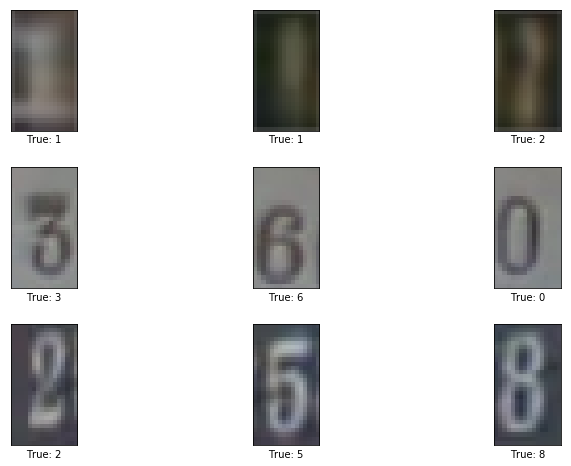

In [14]:
plot_images(images=test_imgs[900:909], cls_true=test_lbls[900:909], smooth=False)

**Shuffle training set**

In [7]:
def shuffle_data(data):
    indices = np.arange(data[0].shape[0]);
    np.random.shuffle(indices)
    return [d[indices] for d in data]
X_train, Y_train = shuffle_data([X_train, Y_train])

**Train and test NN**

In [8]:
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.nn import dropout, relu
from tensorflow.layers import batch_normalization as bnorm
from IPython.display import clear_output

c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [9]:
X_train_flat = X_train.reshape([-1, digh * digw * color_channels])
X_test_flat = X_test.reshape([-1, digh * digw * color_channels])
X_train_flat.shape, X_test_flat.shape

((73251, 1392), (26032, 1392))

In [10]:
Y_train_oh = np.ndarray((Y_train.shape[0], 10))
Y_test_oh = np.ndarray((Y_test.shape[0], 10))
for i in range(Y_train.shape[0]):
    Y_train_oh[i, Y_train[i]] = 1
for i in range(Y_test.shape[0]):
    Y_test_oh[i, Y_test[i]] = 1

In [47]:
model_name = "nn_model"
batch_size = 256
n_epochs = 300
learning_rate = 0.0001
# learning_rate_gd = 0.0001
train_set_test_frac = 0.1  # Get training accuracy for random 10% subset of train set (~7k samples)
log_period_batches = 50

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs = X_train_flat[current_i:current_i + b_size]
    ys = Y_train_oh[current_i:current_i + b_size]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, ys

# Reset tensor graph
n_train = X_train_flat.shape[0]
n_feats = X_train_flat.shape[1]
n_classes = Y_train_oh.shape[1]
tf.reset_default_graph()
izer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float32, [None, n_feats])
y = tf.placeholder(tf.float32, [None, n_classes])
n_train_test = int(train_set_test_frac * n_train)
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

l1_neurons = 4096
l2_neurons = 4096
l3_neurons = 4096
l4_neurons = 4096
l5_neurons = 4096

Wl1 = tf.Variable(izer((n_feats, l1_neurons)))
bl1 = tf.Variable(izer((l1_neurons,)))
Wl2 = tf.Variable(izer((l1_neurons, l2_neurons)))
bl2 = tf.Variable(izer((l2_neurons,)))
Wl3 = tf.Variable(izer((l2_neurons, l3_neurons)))
bl3 = tf.Variable(izer((l3_neurons,)))
Wl4 = tf.Variable(izer((l3_neurons, l4_neurons)))
bl4 = tf.Variable(izer((l4_neurons,)))
Wl5 = tf.Variable(izer((l4_neurons, l5_neurons)))
bl5 = tf.Variable(izer((l5_neurons,)))
Y_W1 = tf.Variable(izer([l5_neurons, n_classes]))
Y_b1 = tf.Variable(izer([n_classes]))

llayer_1 = bnorm(tf.matmul(x, Wl1) + bl1)
llayer_2 = bnorm(relu(tf.matmul(llayer_1, Wl2) + bl2))
llayer_3 = bnorm(relu(tf.matmul(llayer_2, Wl3) + bl3))
llayer_4 = bnorm(relu(tf.matmul(llayer_3, Wl4) + bl4))
llayer_5 = bnorm(tf.matmul(llayer_4, Wl5) + bl5)
logits = tf.matmul(llayer_5, Y_W1) + Y_b1

# Define loss and training step
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_gd).minimize(loss)

# Define basic accuracy computation (actual house number accuracy is done later)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(
    logits, 1), tf.argmax(y, 1)), tf.float32))

# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()

Training accuracy, Testing accuracy, Training loss, Testing loss
Epoch 5 : 0.9255 0.8238 0.2364 0.694  Best test acc: 0.8317


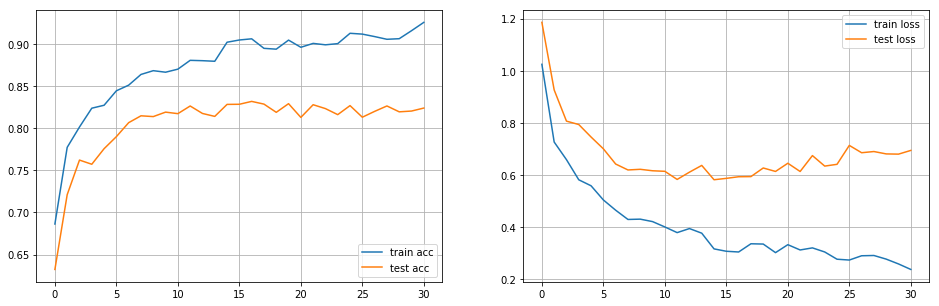

Batch 1600 complete

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    while epochs_completed < n_epochs:
        
        batch_i += 1
        batch_xs, batch_ys = next_batch(batch_size)
        sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
        sys_pr('\rBatch '+ str(batch_i) + ' complete')

        if batch_i % log_period_batches == 0:

            # Get random sample of 10% of the training dataset
            indices = np.random.choice(n_train, n_train_test, replace=False)
            n_train_test_batch = 256
            train_ls, train_as = [], []
            for j in range(n_train_test // n_train_test_batch):
                o = j * n_train_test_batch
                train_l, train_a = sess.run([loss, accuracy], feed_dict={
                    x: X_train_flat[indices][o:o + n_train_test_batch],
                    y: Y_train_oh[indices][o:o + n_train_test_batch]})
                train_ls.append(train_l)
                train_as.append(train_a)

            n_test_batch = 256
            test_ls, test_as = [], []
            for j in range(n_test // n_test_batch):
                o = j * n_test_batch
                test_l, test_a = sess.run([loss, accuracy], feed_dict={
                    x: X_test_flat[o:o + n_test_batch],
                    y: Y_test_oh[o:o + n_test_batch]})
                test_ls.append(test_l)
                test_as.append(test_a)

            train_a, train_l = np.mean(train_as), np.mean(train_ls)
            test_a, test_l = np.mean(test_as), np.mean(test_ls)
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                create_folder("models")
                create_folder("models/" + model_name)
                saver.save(sess, "./models/" + model_name + '/' + model_name)
                
            clear_output()
            print("Training accuracy, Testing accuracy, " + \
                  "Training loss, Testing loss")
            print("Epoch", epochs_completed, ':',
                  round(train_a, 4), round(test_a, 4),
                  round(train_l, 4), round(test_l, 4),
                  " Best test acc:", round(best_acc, 4))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')
    
            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

Load and test trained NN

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./models/" + model_name + '/' + model_name)

    # Get random sample of 10% of the training dataset
    indices = np.random.choice(n_train, n_train_test, replace=False)
    n_train_test_batch = 256
    train_ls, train_as = [], []
    for j in range(n_train_test // n_train_test_batch):
        o = j * n_train_test_batch
        train_l, train_a = sess.run([loss, accuracy], feed_dict={
            x: X_train_flat[indices][o:o + n_train_test_batch],
            y: Y_train_oh[indices][o:o + n_train_test_batch]})
        train_ls.append(train_l)
        train_as.append(train_a)

    n_test_batch = 256
    test_ls, test_as = [], []
    for j in range(n_test // n_test_batch):
        o = j * n_test_batch
        test_l, test_a = sess.run([loss, accuracy], feed_dict={
            x: X_test_flat[o:o + n_test_batch],
            y: Y_test_oh[o:o + n_test_batch]})
        test_ls.append(test_l)
        test_as.append(test_a)

    train_a, train_l = np.mean(train_as), np.mean(train_ls)
    test_a, test_l = np.mean(test_as), np.mean(test_ls)

    clear_output()
    print("Training accuracy, Testing accuracy, " + \
          "Training loss, Testing loss")
    print("Results:", train_a, test_a, train_l, test_l)

**Train and test Dropout NN**

In [10]:
from tensorflow.nn import dropout

In [25]:
model_name = "dropout_model"
batch_size = 512
n_epochs = 300
learning_rate = 0.00005
dropout_keep_prob = 0.6
# learning_rate_gd = 0.0001
train_set_test_frac = 0.1  # Get training accuracy for random 10% subset of train set (~7k samples)
log_period_batches = 100

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs = X_train_flat[current_i:current_i + b_size]
    ys = Y_train_oh[current_i:current_i + b_size]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, ys

# Reset tensor graph
n_train = X_train_flat.shape[0]
n_feats = X_train_flat.shape[1]
n_classes = Y_train_oh.shape[1]
tf.reset_default_graph()
izer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float32, [None, n_feats])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_p = tf.placeholder(tf.float32)
n_train_test = int(train_set_test_frac * n_train)
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

l1_neurons = 1536
l2_neurons = 1536
l3_neurons = 1536
l4_neurons = 1536
l5_neurons = 1536

Wl1 = tf.Variable(izer((n_feats, l1_neurons)))
bl1 = tf.Variable(izer((l1_neurons,)))
Wl2 = tf.Variable(izer((l1_neurons, l2_neurons)))
bl2 = tf.Variable(izer((l2_neurons,)))
Wl3 = tf.Variable(izer((l2_neurons, l3_neurons)))
bl3 = tf.Variable(izer((l3_neurons,)))
Wl4 = tf.Variable(izer((l3_neurons, l4_neurons)))
bl4 = tf.Variable(izer((l4_neurons,)))
Wl5 = tf.Variable(izer((l4_neurons, l5_neurons)))
bl5 = tf.Variable(izer((l5_neurons,)))
Y_W1 = tf.Variable(izer([l5_neurons, n_classes]))
Y_b1 = tf.Variable(izer([n_classes]))

llayer_1 = bnorm(tf.matmul(x, Wl1) + bl1)
llayer_2 = bnorm(dropout(relu(tf.matmul(llayer_1, Wl2) + bl2), keep_p))
llayer_3 = bnorm(dropout(relu(tf.matmul(llayer_2, Wl3) + bl3), keep_p))
llayer_4 = bnorm(dropout(relu(tf.matmul(llayer_3, Wl4) + bl4), keep_p))
llayer_5 = bnorm(tf.matmul(llayer_4, Wl5) + bl5)
logits = tf.matmul(llayer_5, Y_W1) + Y_b1

# Define loss and training step
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_gd).minimize(loss)

# Define basic accuracy computation (actual house number accuracy is done later)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(
    logits, 1), tf.argmax(y, 1)), tf.float32))

# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()

Training accuracy, Testing accuracy, Training loss, Testing loss
Epoch 51 : 0.9876 0.8693 0.0494 0.5909  Best test acc: 0.8712


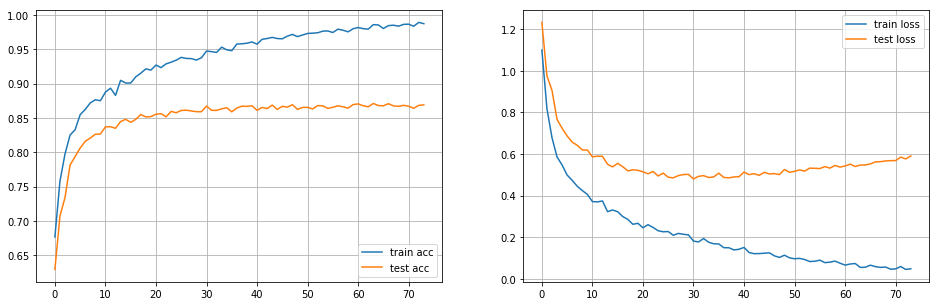

Batch 7460 complete

KeyboardInterrupt: 

In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    while epochs_completed < n_epochs:
        
        batch_i += 1
        batch_xs, batch_ys = next_batch(batch_size)
        sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys, keep_p: dropout_keep_prob})
        sys_pr('\rBatch '+ str(batch_i) + ' complete')

        if batch_i % log_period_batches == 0:

            # Get random sample of 10% of the training dataset
            indices = np.random.choice(n_train, n_train_test, replace=False)
            n_train_test_batch = 256
            train_ls, train_as = [], []
            for j in range(n_train_test // n_train_test_batch):
                o = j * n_train_test_batch
                train_l, train_a = sess.run([loss, accuracy], feed_dict={keep_p: 1.0,
                    x: X_train_flat[indices][o:o + n_train_test_batch],
                    y: Y_train_oh[indices][o:o + n_train_test_batch]})
                train_ls.append(train_l)
                train_as.append(train_a)

            n_test_batch = 256
            test_ls, test_as = [], []
            for j in range(n_test // n_test_batch):
                o = j * n_test_batch
                test_l, test_a = sess.run([loss, accuracy], feed_dict={keep_p: 1.0,
                    x: X_test_flat[o:o + n_test_batch],
                    y: Y_test_oh[o:o + n_test_batch]})
                test_ls.append(test_l)
                test_as.append(test_a)

            train_a, train_l = np.mean(train_as), np.mean(train_ls)
            test_a, test_l = np.mean(test_as), np.mean(test_ls)
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                create_folder("models")
                create_folder("models/" + model_name)
                saver.save(sess, "./models/" + model_name + '/' + model_name)
                
            clear_output()
            print("Training accuracy, Testing accuracy, " + \
                  "Training loss, Testing loss")
            print("Epoch", epochs_completed, ':',
                  round(train_a, 4), round(test_a, 4),
                  round(train_l, 4), round(test_l, 4),
                  " Best test acc:", round(best_acc, 4))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')
    
            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

Load and test trained Dropout NN

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./models/" + model_name + '/' + model_name)

    # Get random sample of 10% of the training dataset
    indices = np.random.choice(n_train, n_train_test, replace=False)
    n_train_test_batch = 256
    train_ls, train_as = [], []
    for j in range(n_train_test // n_train_test_batch):
        o = j * n_train_test_batch
        train_l, train_a = sess.run([loss, accuracy], feed_dict={
            x: X_train_flat[indices][o:o + n_train_test_batch],
            y: Y_train_oh[indices][o:o + n_train_test_batch]})
        train_ls.append(train_l)
        train_as.append(train_a)

    n_test_batch = 256
    test_ls, test_as = [], []
    for j in range(n_test // n_test_batch):
        o = j * n_test_batch
        test_l, test_a = sess.run([loss, accuracy], feed_dict={
            x: X_test_flat[o:o + n_test_batch],
            y: Y_test_oh[o:o + n_test_batch]})
        test_ls.append(test_l)
        test_as.append(test_a)

    train_a, train_l = np.mean(train_as), np.mean(train_ls)
    test_a, test_l = np.mean(test_as), np.mean(test_ls)

    clear_output()
    print("Training accuracy, Testing accuracy, " + \
          "Training loss, Testing loss")
    print("Results:", train_a, test_a, train_l, test_l)

**Train and test Digit CNN**

In [27]:
from tensorflow.nn import conv2d, max_pool

In [31]:
model_name = "digcnn_model"
batch_size = 512
n_epochs = 300
learning_rate = 0.00005
dropout_keep_prob = 0.6
# learning_rate_gd = 0.0001
train_set_test_frac = 0.1  # Get training accuracy for random 10% subset of train set (~7k samples)
log_period_batches = 100

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs = X_train[current_i:current_i + b_size]
    ys = Y_train_oh[current_i:current_i + b_size]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, ys

# Reset tensor graph
n_train = X_train_flat.shape[0]
n_feats = X_train_flat.shape[1]
n_classes = Y_train_oh.shape[1]
tf.reset_default_graph()
izer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float32, [None, digh, digw, color_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_p = tf.placeholder(tf.float32)
n_train_test = int(train_set_test_frac * n_train)
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

s_1 = 48
s_2 = 64
s_3 = 128
s_4 = 160
# s_5 = 192
l1_neurons = 1536
l2_neurons = 1536
# l3_neurons = 1536
# l4_neurons = 1536
# l5_neurons = 1536

W1 = tf.Variable(izer((5, 5, color_channels, s_1)))
#b1 = tf.Variable(izer((image_size, image_size, s_1)))
W2 = tf.Variable(izer((5, 5, s_1, s_2)))
#b2 = tf.Variable(izer((15, 8, s_2)))
W3 = tf.Variable(izer((5, 5, s_2, s_3)))
#b3 = tf.Variable(izer((15, 8, s_3)))
W4 = tf.Variable(izer((5, 5, s_3, s_4)))
#b4 = tf.Variable(izer((8, 4, s_4)))
conv_output_neurons = 8 * 4 * s_4

Wl1 = tf.Variable(izer((conv_output_neurons, l1_neurons)))
bl1 = tf.Variable(izer((l1_neurons,)))
Wl2 = tf.Variable(izer((l1_neurons, l2_neurons)))
bl2 = tf.Variable(izer((l2_neurons,)))
Wl3 = tf.Variable(izer((l2_neurons, l3_neurons)))
bl3 = tf.Variable(izer((l3_neurons,)))
Wl4 = tf.Variable(izer((l3_neurons, l4_neurons)))
bl4 = tf.Variable(izer((l4_neurons,)))
Wl5 = tf.Variable(izer((l4_neurons, l5_neurons)))
bl5 = tf.Variable(izer((l5_neurons,)))
Y_W1 = tf.Variable(izer([l5_neurons, n_classes]))
Y_b1 = tf.Variable(izer([n_classes]))

conv_1 = conv2d(x, W1, strides=[1, 1, 1, 1], padding='SAME')# + b1
maxpool_1 = bnorm(dropout(max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'), keep_p))
conv_2 = conv2d(maxpool_1, W2, strides=[1, 1, 1, 1], padding='SAME')# + b2
maxpool_2 = bnorm(dropout(relu(max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))
conv_3 = conv2d(maxpool_2, W3, strides=[1, 1, 1, 1], padding='SAME')# + b3
maxpool_3 = bnorm(dropout(relu(max_pool(conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')), keep_p))
conv_4 = conv2d(maxpool_3, W4, strides=[1, 1, 1, 1], padding='SAME')# + b4
maxpool_4 = bnorm(dropout(relu(max_pool(conv_4, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))

flattened = tf.reshape(maxpool_4, [-1, conv_output_neurons]) # Flatten
llayer_1 = bnorm(tf.matmul(flattened, Wl1) + bl1)
llayer_2 = bnorm(dropout(relu(tf.matmul(llayer_1, Wl2) + bl2), keep_p))
# llayer_3 = bnorm(dropout(relu(tf.matmul(llayer_2, Wl3) + bl3), keep_p))
# llayer_4 = bnorm(dropout(relu(tf.matmul(llayer_3, Wl4) + bl4), keep_p))
llayer_3 = bnorm(tf.matmul(llayer_2, Wl5) + bl5)
logits = tf.matmul(llayer_3, Y_W1) + Y_b1

# Define loss and training step
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_gd).minimize(loss)

# Define basic accuracy computation (actual house number accuracy is done later)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(
    logits, 1), tf.argmax(y, 1)), tf.float32))

# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()

Training accuracy, Testing accuracy, Training loss, Testing loss
Epoch 251 : 1.0 0.9431 0.0002 0.4065  Best test acc: 0.9439


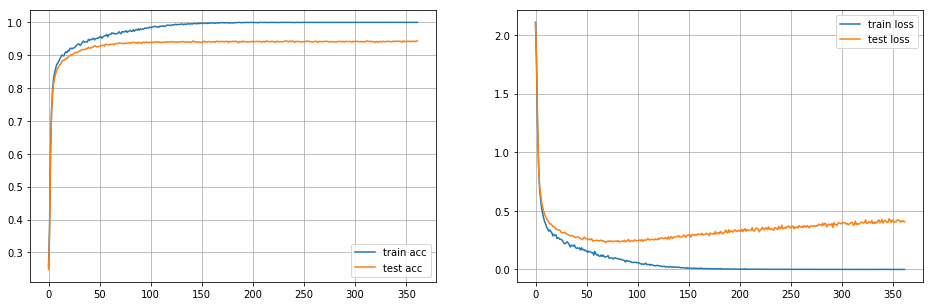

Batch 36279 complete

KeyboardInterrupt: 

In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    while epochs_completed < n_epochs:
        
        batch_i += 1
        batch_xs, batch_ys = next_batch(batch_size)
        sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys, keep_p: dropout_keep_prob})
        sys_pr('\rBatch '+ str(batch_i) + ' complete')

        if batch_i % log_period_batches == 0:

            # Get random sample of 10% of the training dataset
            indices = np.random.choice(n_train, n_train_test, replace=False)
            n_train_test_batch = 256
            train_ls, train_as = [], []
            for j in range(n_train_test // n_train_test_batch):
                o = j * n_train_test_batch
                train_l, train_a = sess.run([loss, accuracy], feed_dict={keep_p: 1.0,
                    x: X_train[indices][o:o + n_train_test_batch],
                    y: Y_train_oh[indices][o:o + n_train_test_batch]})
                train_ls.append(train_l)
                train_as.append(train_a)

            n_test_batch = 256
            test_ls, test_as = [], []
            for j in range(n_test // n_test_batch):
                o = j * n_test_batch
                test_l, test_a = sess.run([loss, accuracy], feed_dict={keep_p: 1.0,
                    x: X_test[o:o + n_test_batch],
                    y: Y_test_oh[o:o + n_test_batch]})
                test_ls.append(test_l)
                test_as.append(test_a)

            train_a, train_l = np.mean(train_as), np.mean(train_ls)
            test_a, test_l = np.mean(test_as), np.mean(test_ls)
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                create_folder("models")
                create_folder("models/" + model_name)
                saver.save(sess, "./models/" + model_name + '/' + model_name)
                
            clear_output()
            print("Training accuracy, Testing accuracy, " + \
                  "Training loss, Testing loss")
            print("Epoch", epochs_completed, ':',
                  round(train_a, 4), round(test_a, 4),
                  round(train_l, 4), round(test_l, 4),
                  " Best test acc:", round(best_acc, 4))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')
    
            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

Load and test trained Digit CNN

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./models/" + model_name + '/' + model_name)

    # Get random sample of 10% of the training dataset
    indices = np.random.choice(n_train, n_train_test, replace=False)
    n_train_test_batch = 256
    train_ls, train_as = [], []
    for j in range(n_train_test // n_train_test_batch):
        o = j * n_train_test_batch
        train_l, train_a = sess.run([loss, accuracy], feed_dict={
            x: X_train[indices][o:o + n_train_test_batch],
            y: Y_train_oh[indices][o:o + n_train_test_batch]})
        train_ls.append(train_l)
        train_as.append(train_a)

    n_test_batch = 256
    test_ls, test_as = [], []
    for j in range(n_test // n_test_batch):
        o = j * n_test_batch
        test_l, test_a = sess.run([loss, accuracy], feed_dict={
            x: X_test[o:o + n_test_batch],
            y: Y_test_oh[o:o + n_test_batch]})
        test_ls.append(test_l)
        test_as.append(test_a)

    train_a, train_l = np.mean(train_as), np.mean(train_ls)
    test_a, test_l = np.mean(test_as), np.mean(test_ls)

    clear_output()
    print("Training accuracy, Testing accuracy, " + \
          "Training loss, Testing loss")
    print("Results:", train_a, test_a, train_l, test_l)